# CE7454 Project - Group 01

# Sleep stages classification using EEG signals

#### Rakaraddi Appan

Link to the Github repository is [here](https://github.com/ismail0T/CE7454_project) 

To download the dataset for running the notebooks, it is shared [here](https://drive.google.com/open?id=1I29pxdFzzxvKDmuy4NAKGcCpfepLtIDQ)

There are 6 datasets in total tested on the models. In this notebook, one of them is being used to validate the architecture. The results of training and testing on other datasets can be found in the other notebooks in the Github repository shared above.

We'll use three different architectures of 1D Convolution for the classification task on multiple number of datasets. 

## Model 1: Type-1 CNN Architecture

Let's discuss the first Convolution architecture that we'll deploy in the classification task.

<img src="images/ConvFreq.png" alt="Model 1">

This architecture has an initial large filter window for feature detection on the time series data. This architecture basically has 4 1D Convolutional layers, 2 Maxpooling layers and a Dropout layer. All the activation functions considered between the layers is the non-linear activation function ReLu. We'll later compare the performance of this architecture with the other architectures later on. 

In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import torch.nn.functional as F
import random
from matplotlib import pyplot as plt

# Data loader

Load the data from the drive into a training and a test set. Basically, there are two different files already preprocessed: Training dataset file and Test dataset file. And we'll display the datasize and shape below. To reproduce the results, download the train and test datasets used [here](https://drive.google.com/open?id=1jdCgv8Cb9hmhF1YjwFxwI-I-CjWDoc6M). Ensure the datsets and the notebook are saved in the same directory.

In [259]:
trainer=np.load("trainData__SMOTE_all_10s_f5.npz","rb")
tester=np.load("trainData__SMOTE_all_10s_f5_TEST.npz", "rb")

x_train=torch.from_numpy(trainer['x'][:])
y_train=torch.from_numpy(trainer['y'][:])
y_train=y_train.long()

x_test=torch.from_numpy(tester['x'][:])
y_test=torch.from_numpy(tester['y'][:])
y_test=y_test.long()

print("Training data size= ",x_train.size(), "\t\tTraining label size= ",y_train.size(),sep="\t")
print("Testing data size= ", x_test.size(), "\t\tTesting label size= ", y_test.size(),sep="\t")

#REshape x_test and y_test into x_train and y_train dimensions

x_test=x_test.view(-1,3000)
y_test=y_test.view(-1,)

print("\n\nReshaped Testing data size= ", x_test.size(), "\t\tReshaped Testing label size= ", y_test.size(),sep="\t")

Training data size= 	torch.Size([56940, 3000])			Training label size= 	torch.Size([56940])
Testing data size= 	torch.Size([1847, 1, 3000])			Testing label size= 	torch.Size([1847, 1])


Reshaped Testing data size= 	torch.Size([1847, 3000])			Reshaped Testing label size= 	torch.Size([1847])


In [260]:
std= x_train.std()
mean=x_train.mean()
batch_size = 100
learning_rate = 0.01
range_val=len(x_train)-batch_size

print(std,mean,sep="  ")

tensor(0.9657)  tensor(-1.0283e-09)


# Architecture

In [0]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        
        #Pool and activation fn's here 
        activation=nn.ReLU()       
        pool_8 = nn.MaxPool1d(kernel_size=8,stride=8) #Size=8
        pool_4 = nn.MaxPool1d(kernel_size=4,stride=4) #Size=4
        pool_2 = nn.MaxPool1d(kernel_size=2,stride=2) #Size=2
        
        #Dropout
        self.drop_out = nn.Dropout()
        
        #ConvNet freq
        
        conv1_f=nn.Conv1d(1,  64,  kernel_size=400, stride=50,padding=1)
        self.conv2_f=nn.Conv1d(64, 128, kernel_size=6,   stride=1,padding=1)
        self.conv3_f=nn.Conv1d(128,128, kernel_size=6,   stride=1,padding=1)
        conv4_f=nn.Conv1d(128,128, kernel_size=6,   stride=1,padding=1)
        
        
        #Layers freq
        
        self.layer1_f=nn.Sequential(conv1_f, activation, pool_4)
        self.layer2_f=nn.Sequential(conv4_f, activation, pool_2)
        
        self.layer=nn.Sequential(nn.Linear(256,5,bias=False),activation)
        
        
        
        
   
    def forward(self,x):
        #Freq here
        
        out_f=self.layer1_f(x)
        out_f=self.conv2_f(out_f)
        out_f=self.conv3_f(out_f)
        out_f=self.layer2_f(out_f)

        #print(out_f.size())
        #out=self.drop_out(out)   #DropOut
        out=out_f.view(-1,256)
        
        out=self.layer(out)
        
        #print("Output size=  ",size)
       # print("modified= ",out.reshape(-1) )
        return out

# Initialization

In [262]:
net=ConvNet()
print(net)
net = net.to(torch.device("cuda"))

mean=mean.to(torch.device("cuda"))

std=std.to(torch.device("cuda"))
criterion = nn.CrossEntropyLoss()

ConvNet(
  (drop_out): Dropout(p=0.5, inplace=False)
  (conv2_f): Conv1d(64, 128, kernel_size=(6,), stride=(1,), padding=(1,))
  (conv3_f): Conv1d(128, 128, kernel_size=(6,), stride=(1,), padding=(1,))
  (layer1_f): Sequential(
    (0): Conv1d(1, 64, kernel_size=(400,), stride=(50,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2_f): Sequential(
    (0): Conv1d(128, 128, kernel_size=(6,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer): Sequential(
    (0): Linear(in_features=256, out_features=5, bias=False)
    (1): ReLU()
  )
)


# Error generate

In [0]:
def get_error(scores,labels):
  
  batch_size = scores.size(0)
  predicted_labels = scores.argmax(dim=1)
  indicator = (predicted_labels == labels)
  num_matches=indicator.sum()
  
  return 1-num_matches.float()/batch_size

# Test set check

In [0]:
def eval_on_test_set(error_axis_test):

    running_error=0
    num_batches=0

    for i in range(0,len(x_test)-batch_size,batch_size):

        minibatch_data =  x_test[i:i+batch_size].unsqueeze(dim=1)
        minibatch_label= y_test[i:i+batch_size]

        minibatch_data=minibatch_data.to(torch.device("cuda"))
        minibatch_label=minibatch_label.to(torch.device("cuda"))
        
        inputs = (minibatch_data - mean)/std  

        scores=net( inputs ) 

        error = get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1


    total_error = running_error/num_batches
    error_axis_test.append(total_error*100)
    print( 'error rate on test set =', total_error*100 ,'percent')
    return error_axis_test

# Training the network

The model is trained for over 200 epochs with initial learning rate=0.01 and batch_size=100. The learning rate is halved every 100 epochs and the trained model is tested for accuracy on the test dataset for every 20 epochs. The error on training set and the testset data is displayed for every 20 epochs.

In [265]:
start=time.time()
epoch_axis_train=list()
error_axis_train=list()

error_axis_test=list()
epoch_axis_test=list()


for epoch in range(1,200):
    if epoch%100==0:
      learning_rate=learning_rate/2   
       
    optimizer=torch.optim.SGD( net.parameters() , lr=learning_rate )
        
    running_loss=0
    running_error=0
    num_batches=0
    
    
    shuffled_indices=torch.randperm(range_val)
    
 
    for count in range(0,range_val,batch_size):
        
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
             
        indices=shuffled_indices[count:count+batch_size]
        minibatch_data =  x_train[indices].unsqueeze(dim=1)
        minibatch_label=  y_train[indices]
        
        #print("minibatch_data= ",minibatch_data.size())
        #print("minibatch_label= ",minibatch_label.size())
        
        
        minibatch_data=minibatch_data.to(torch.device("cuda"))
        minibatch_label=minibatch_label.to(torch.device("cuda"))
        
        inputs = (minibatch_data - mean)/std      
        
        inputs.requires_grad_()
                
        scores=net( inputs ) 
        #print("SCores=", scores.size())

        loss =  criterion( scores , minibatch_label) 
          
        loss.backward()
        
        optimizer.step()
        

               
        running_loss += loss.detach().item()
        
        error = get_error( scores.detach() , minibatch_label)
        running_error += error.item()
          
        num_batches+=1        
    
    
    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60

    if epoch%20==0:
      print('epoch=',epoch, '\t time=', elapsed,'min', '\t learning rate=', learning_rate  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
      error_axis_test = eval_on_test_set(error_axis_test)
      epoch_axis_test.append(epoch)
      print(' ')
    
    epoch_axis_train.append(epoch)
    error_axis_train.append(error*100)

epoch= 20 	 time= 1.2383256395657858 min 	 learning rate= 0.01 	 loss= 0.705570169932394 	 error= 18.944641733001948 percent
error rate on test set = 18.666669064097935 percent
 
epoch= 40 	 time= 2.477038864294688 min 	 learning rate= 0.01 	 loss= 0.2825465754512534 	 error= 10.228472853796344 percent
error rate on test set = 16.888891657193504 percent
 
epoch= 60 	 time= 3.715362612406413 min 	 learning rate= 0.01 	 loss= 0.16655828234181463 	 error= 5.884008918789023 percent
error rate on test set = 21.444445848464966 percent
 
epoch= 80 	 time= 4.9515663663546245 min 	 learning rate= 0.01 	 loss= 0.07914814026617104 	 error= 2.443764048427186 percent
error rate on test set = 18.8333359029558 percent
 
epoch= 100 	 time= 6.189797449111938 min 	 learning rate= 0.005 	 loss= 0.01685666119571782 	 error= 0.12302343162375719 percent
error rate on test set = 19.222224089834423 percent
 
epoch= 120 	 time= 7.427377239863078 min 	 learning rate= 0.005 	 loss= 0.007268318158831375 	 error= 

# Training set plots

2 statistical plots are plotted for the study of how the model was trained based on the errors on the training dataset with the first plot showing variation of the error w.r.t. epochs on the training dataset. The second is a pie plot which shows the average number of correct predictions and incorrect predictions.

Mean error on train set= 6.143216 % 



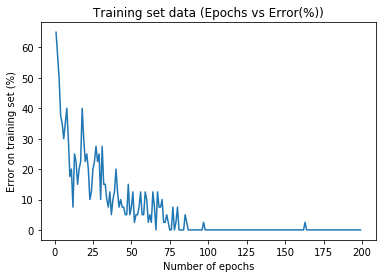

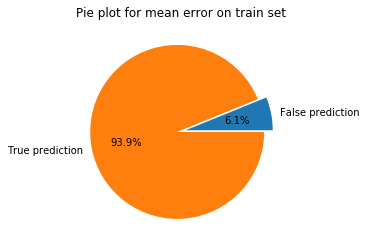

In [266]:
l=list()
for i in error_axis_train:
  l.append(i.cpu().detach().numpy())

mean=np.mean(l)
print("Mean error on train set=",mean,"% \n")
plt.plot(epoch_axis_train,error_axis_train)
plt.title("Training set data (Epochs vs Error(%))")
plt.xlabel("Number of epochs")
plt.ylabel("Error on training set (%)")
plt.show()
explode=(0.05,0.05)

print("\n")
labels=["False prediction","True prediction"]
plt.pie([mean,100-mean],labels=labels,autopct='%1.1f%%',explode=explode)
plt.title("Pie plot for mean error on train set")
plt.show()

# Test set plots

Same as with test set dataset, 2 statistical plots: first no. of epochs vs error rate and the second one a pie plot denoting the minimum error percentage predicted on the test dataset for every 20 epochs on which it is tested on. 

Mean error on test set= 19.25308851548183 % 



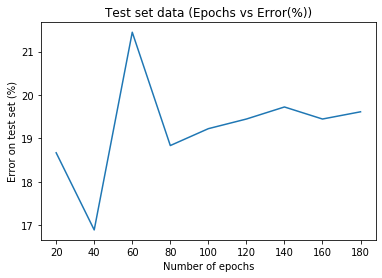

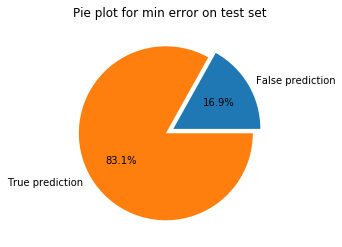

In [267]:
print("Mean error on test set=",np.mean(error_axis_test),"% \n")
plt.plot(epoch_axis_test,error_axis_test)
plt.title("Test set data (Epochs vs Error(%))")
plt.xlabel("Number of epochs")
plt.ylabel("Error on test set (%)")
plt.show()
print("\n")
plt.pie([min(error_axis_test),100-min(error_axis_test)],labels=labels,autopct='%1.1f%%',explode=explode)
plt.title("Pie plot for min error on test set")
plt.show()

## Conclusion

This architecture provided a mean error of around 19% on the test dataset.

## Model 2: Type-2 CNN Architecture

We will see a variation of the Type-1 CNN Architecture here. This is somewhat similar to the first, but the kernel sizes of the Convolutional layers are different and this architecture on the overall testcases provided a more stable accuracy compared to the first. For some of the test dataset run using the first architecture, there was a huge variance in the percentage of correct output prediction (with error margin varying between 30% to 90%).

The architecture is as shown below:
<img src="images/ConvTime.png" alt="Model 2">

# Architecture

In [0]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        
        #Pool and activation fn's here 
        activation=nn.ReLU()       
        pool_8 = nn.MaxPool1d(kernel_size=8,stride=8) #Size=8
        pool_4 = nn.MaxPool1d(kernel_size=4,stride=4) #Size=4
        pool_2 = nn.MaxPool1d(kernel_size=2,stride=2) #Size=2
        
        #Dropout
        self.drop_out = nn.Dropout()
        
        
        #ConvNet time
        conv1_t=nn.Conv1d (1, 64, kernel_size=50,stride=6,padding=1)
        self.conv2_t=nn.Conv1d(64,128,kernel_size=8,stride=1,padding=1)
        self.conv3_t=nn.Conv1d(128,128,kernel_size=8,stride=1,padding=1)
        conv4_t=nn.Conv1d(128,128,kernel_size=8,stride=1,padding=1)
        
        #Layers time
        self.layer1_t=nn.Sequential(conv1_t,activation,pool_8)
        self.layer2_t=nn.Sequential(conv4_t,activation,pool_4)      
        
        
        self.layer=nn.Sequential(nn.Linear(1408,5,bias=False),activation)
        
        
    def forward(self,x):
        
        
        #Time here
        out_t=self.layer1_t(x)
        out_t=self.drop_out(out_t)  #DropOut
        out_t=self.conv2_t(out_t)
        out_t=self.conv3_t(out_t)
        out_t=self.layer2_t(out_t)
        out=out_t.view(-1,1408)
        
        
        out=self.layer(out)
        
        return out

# Initialization

In [115]:
net=ConvNet()
print(net)
net = net.to(torch.device("cuda"))

mean=mean.to(torch.device("cuda"))

std=std.to(torch.device("cuda"))
criterion = nn.CrossEntropyLoss()

ConvNet(
  (drop_out): Dropout(p=0.5, inplace=False)
  (conv2_t): Conv1d(64, 128, kernel_size=(8,), stride=(1,), padding=(1,))
  (conv3_t): Conv1d(128, 128, kernel_size=(8,), stride=(1,), padding=(1,))
  (layer1_t): Sequential(
    (0): Conv1d(1, 64, kernel_size=(50,), stride=(6,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2_t): Sequential(
    (0): Conv1d(128, 128, kernel_size=(8,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (layer): Sequential(
    (0): Linear(in_features=1408, out_features=5, bias=False)
    (1): ReLU()
  )
)


# Test set check

In [0]:
def eval_on_test_set(error_axis_test):

    running_error=0
    num_batches=0

    for i in range(0,len(x_test)-batch_size,batch_size):

        minibatch_data =  x_test[i:i+batch_size].unsqueeze(dim=1)
        minibatch_label= y_test[i:i+batch_size]

        minibatch_data=minibatch_data.to(torch.device("cuda"))
        minibatch_label=minibatch_label.to(torch.device("cuda"))
        
        inputs = (minibatch_data - mean)/std  

        scores=net( inputs ) 

        error = get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1


    total_error = running_error/num_batches
    error_axis_test.append(total_error*100)
    print( 'error rate on test set =', total_error*100 ,'percent')
    return error_axis_test

# Training the network

In [118]:
start=time.time()
epoch_axis_train=list()
error_axis_train=list()

error_axis_test=list()
epoch_axis_test=list()


for epoch in range(1,200):
    if epoch%100==0:
      learning_rate=learning_rate/2
    
       
    optimizer=torch.optim.SGD( net.parameters() , lr=learning_rate )
        
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(range_val)
 
    for count in range(0,range_val,batch_size):
        
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
             
        indices=shuffled_indices[count:count+batch_size]
        minibatch_data =  x_train[indices].unsqueeze(dim=1)
        minibatch_label=  y_train[indices]
        
        #print("minibatch_data= ",minibatch_data.size())
        #print("minibatch_label= ",minibatch_label.size())
        
        
        minibatch_data=minibatch_data.to(torch.device("cuda"))
        minibatch_label=minibatch_label.to(torch.device("cuda"))
        
        inputs = (minibatch_data - mean)/std      
        
        inputs.requires_grad_()
                
        scores=net( inputs ) 
        #print("SCores=", scores.size())

        loss =  criterion( scores , minibatch_label) 
          
        loss.backward()
        
        optimizer.step()

        running_loss += loss.detach().item()
        
        error = get_error( scores.detach() , minibatch_label)
        running_error += error.item()
          
        num_batches+=1        
    
    
    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60
    
    if epoch%20==0:
      print('epoch=',epoch, '\t time=', elapsed,'min', '\t learning rate=', learning_rate  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
      error_axis_test = eval_on_test_set(error_axis_test)
      epoch_axis_test.append(epoch)
      print(' ')

    epoch_axis_train.append(epoch)
    error_axis_train.append(error*100)
      
    

epoch= 20 	 time= 3.746885120868683 min 	 learning rate= 0.01 	 loss= 0.4738992435860927 	 error= 18.08611808217054 percent
error rate on test set = 15.611113442314995 percent
 
epoch= 40 	 time= 7.492813889185587 min 	 learning rate= 0.01 	 loss= 0.39495319329686657 	 error= 15.057998581385151 percent
error rate on test set = 17.277779512935215 percent
 
epoch= 60 	 time= 11.239299794038137 min 	 learning rate= 0.01 	 loss= 0.34349883686888616 	 error= 12.931460843982931 percent
error rate on test set = 16.388890809482998 percent
 
epoch= 80 	 time= 15.0007843653361 min 	 learning rate= 0.01 	 loss= 0.30077161224843746 	 error= 11.118631193214643 percent
error rate on test set = 15.388891432020399 percent
 
epoch= 100 	 time= 18.74403468767802 min 	 learning rate= 0.005 	 loss= 0.2516430765390396 	 error= 9.283833197843421 percent
error rate on test set = 15.166669421725803 percent
 
epoch= 120 	 time= 22.49238221247991 min 	 learning rate= 0.005 	 loss= 0.23196026761418695 	 error= 8

# Training set plots

Mean error on train set= 12.060302 % 



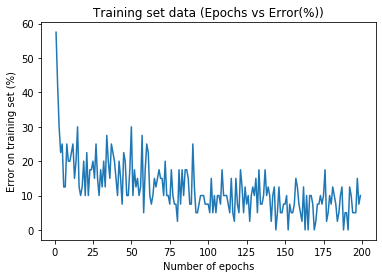

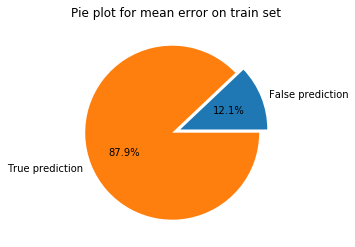

In [119]:
l=list()
for i in error_axis_train:
  l.append(i.cpu().detach().numpy())

mean=np.mean(l)
print("Mean error on train set=",mean,"% \n")
plt.plot(epoch_axis_train,error_axis_train)
plt.title("Training set data (Epochs vs Error(%))")
plt.xlabel("Number of epochs")
plt.ylabel("Error on training set (%)")
plt.show()
explode=(0.05,0.05)

print("\n")
labels=["False prediction","True prediction"]
plt.pie([mean,100-mean],labels=labels,autopct='%1.1f%%',explode=explode)
plt.title("Pie plot for mean error on train set")
plt.show()

# Test set plots

Mean error on test set= 15.944446568135861 % 



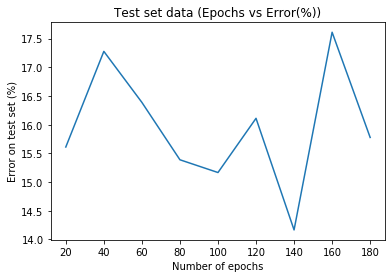

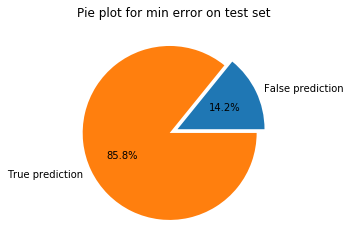

In [120]:
print("Mean error on test set=",np.mean(error_axis_test),"% \n")
plt.plot(epoch_axis_test,error_axis_test)
plt.title("Test set data (Epochs vs Error(%))")
plt.xlabel("Number of epochs")
plt.ylabel("Error on test set (%)")
plt.show()
print("\n")
plt.pie([min(error_axis_test),100-min(error_axis_test)],labels=labels,autopct='%1.1f%%',explode=explode)
plt.title("Pie plot for min error on test set")
plt.show()

## Conclusion

This architecture provided a mean error on the test dataset of around 15% which is lower than that of Architecture 1.

## Model 3: Concatenated CNN Architecture

For the third type, we'll combine the above 2 CNN architectures parallelly and then concatenate the outputs of both the architectures for the best results. This will help in reaping the benefits of both the architectures in parallel and will try to get the best results.

The illustration of this is as shown below:

<img src="images/ConvCon.png" alt="Model 3">


## Architecture

In [0]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        
        #Pool and activation fn's here 
        activation=nn.ReLU()       
        pool_8 = nn.MaxPool1d(kernel_size=8,stride=8) #Size=8
        pool_4 = nn.MaxPool1d(kernel_size=4,stride=4) #Size=4
        pool_2 = nn.MaxPool1d(kernel_size=2,stride=2) #Size=2
        
        #Dropout
        self.drop_out = nn.Dropout()
        
        
        #ConvNet time
        conv1_t=nn.Conv1d (1, 64, kernel_size=50,stride=6,padding=1)
        self.conv2_t=nn.Conv1d(64,128,kernel_size=8,stride=1,padding=1)
        self.conv3_t=nn.Conv1d(128,128,kernel_size=8,stride=1,padding=1)
        conv4_t=nn.Conv1d(128,128,kernel_size=8,stride=1,padding=1)
        
        #Layers time
        self.layer1_t=nn.Sequential(conv1_t,activation,pool_8)
        self.layer2_t=nn.Sequential(conv4_t,activation,pool_4)
        
        #ConvNet freq
        
        conv1_f=nn.Conv1d(1,  64,  kernel_size=400, stride=50,padding=1)
        self.conv2_f=nn.Conv1d(64, 128, kernel_size=6,   stride=1,padding=1)
        self.conv3_f=nn.Conv1d(128,128, kernel_size=6,   stride=1,padding=1)
        conv4_f=nn.Conv1d(128,128, kernel_size=6,   stride=1,padding=1)
        
        
        #Layers freq
        
        self.layer1_f=nn.Sequential(conv1_f, activation, pool_4)
        self.layer2_f=nn.Sequential(conv4_f, activation, pool_2)
        
        self.layer=nn.Sequential(nn.Linear(1664,5,bias=False),activation)
        
        
   
    def forward(self,x):
        
        
        #Time here
        out_t=self.layer1_t(x)
        out_t=self.drop_out(out_t)  #DropOut
        out_t=self.conv2_t(out_t)
        out_t=self.conv3_t(out_t)
        out_t=self.layer2_t(out_t)
        
        #Freq here
        
        out_f=self.layer1_f(x)
        out_f=self.drop_out(out_f)  #DropOut
        out_f=self.conv2_f(out_f)
        out_f=self.conv3_f(out_f)
        out_f=self.layer2_f(out_f)
        
        out=torch.cat((out_t,out_f),2)  #Concat
        out=self.drop_out(out)   #DropOut
       # print(out.size())
        out=out.view(-1,1664)
        
        out=self.layer(out)
        return out

## Initialization

In [110]:
net=ConvNet()
print(net)
net = net.to(torch.device("cuda"))

mean=mean.to(torch.device("cuda"))

std=std.to(torch.device("cuda"))
criterion = nn.CrossEntropyLoss()

ConvNet(
  (drop_out): Dropout(p=0.5, inplace=False)
  (conv2_t): Conv1d(64, 128, kernel_size=(8,), stride=(1,), padding=(1,))
  (conv3_t): Conv1d(128, 128, kernel_size=(8,), stride=(1,), padding=(1,))
  (layer1_t): Sequential(
    (0): Conv1d(1, 64, kernel_size=(50,), stride=(6,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2_t): Sequential(
    (0): Conv1d(128, 128, kernel_size=(8,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2_f): Conv1d(64, 128, kernel_size=(6,), stride=(1,), padding=(1,))
  (conv3_f): Conv1d(128, 128, kernel_size=(6,), stride=(1,), padding=(1,))
  (layer1_f): Sequential(
    (0): Conv1d(1, 64, kernel_size=(400,), stride=(50,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2_f): Sequential(
    (0): Conv1d(128, 1

## Test set check

In [0]:
def eval_on_test_set(error_axis_test):

    running_error=0
    num_batches=0

    for i in range(0,len(x_test)-batch_size,batch_size):

        minibatch_data =  x_test[i:i+batch_size].unsqueeze(dim=1)
        minibatch_label= y_test[i:i+batch_size]

        minibatch_data=minibatch_data.to(torch.device("cuda"))
        minibatch_label=minibatch_label.to(torch.device("cuda"))
        
        inputs = (minibatch_data - mean)/std  

        scores=net( inputs ) 

        error = get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1


    total_error = running_error/num_batches
    error_axis_test.append(total_error*100)
    print( 'error rate on test set =', total_error*100 ,'percent')
    return error_axis_test

## Training the network

In [113]:
start=time.time()
epoch_axis_train=list()
error_axis_train=list()

error_axis_test=list()
epoch_axis_test=list()


for epoch in range(1,200):
    if epoch%100==0:
      learning_rate=learning_rate/2
       
    optimizer=torch.optim.SGD( net.parameters() , lr=learning_rate )
        
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(range_val)
 
    for count in range(0,range_val,batch_size):
        
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
             
        indices=shuffled_indices[count:count+batch_size]
        minibatch_data =  x_train[indices].unsqueeze(dim=1)
        minibatch_label=  y_train[indices]
        
        #print("minibatch_data= ",minibatch_data.size())
        #print("minibatch_label= ",minibatch_label.size())
        
        
        minibatch_data=minibatch_data.to(torch.device("cuda"))
        minibatch_label=minibatch_label.to(torch.device("cuda"))
        
        inputs = (minibatch_data - mean)/std      
        
        inputs.requires_grad_()
                
        scores=net( inputs ) 
        #print("SCores=", scores.size())

        loss =  criterion( scores , minibatch_label) 
          
        loss.backward()
        
        optimizer.step()
        

               
        running_loss += loss.detach().item()
        
        error = get_error( scores.detach() , minibatch_label)
        running_error += error.item()
          
        num_batches+=1        
    
    
    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60
    
    if epoch%20==0:
      print('epoch=',epoch, '\t time=', elapsed,'min', '\t learning rate=', learning_rate  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
      error_axis_test = eval_on_test_set(error_axis_test)
      epoch_axis_test.append(epoch)
      print(' ')
      
    epoch_axis_train.append(epoch)
    error_axis_train.append(error*100)

epoch= 20 	 time= 4.051901479562123 min 	 learning rate= 0.01 	 loss= 0.4977868239154715 	 error= 19.027242918215652 percent
error rate on test set = 14.833335081736246 percent
 
epoch= 40 	 time= 8.10254499912262 min 	 learning rate= 0.01 	 loss= 0.4434844673675058 	 error= 16.935854584554797 percent
error rate on test set = 17.166669170061745 percent
 
epoch= 60 	 time= 12.223389689127604 min 	 learning rate= 0.01 	 loss= 0.40746572210415805 	 error= 15.398947666734719 percent
error rate on test set = 12.833335333400303 percent
 
epoch= 80 	 time= 16.225263130664825 min 	 learning rate= 0.01 	 loss= 0.3801605558720121 	 error= 14.473640038803717 percent
error rate on test set = 13.222224513689676 percent
 
epoch= 100 	 time= 20.340491354465485 min 	 learning rate= 0.005 	 loss= 0.3404576430892693 	 error= 12.804044214828572 percent
error rate on test set = 14.222225215699938 percent
 
epoch= 120 	 time= 24.471998258431753 min 	 learning rate= 0.005 	 loss= 0.3226662068144927 	 error=

# Training set plots

Mean error on train set= 14.572865 % 



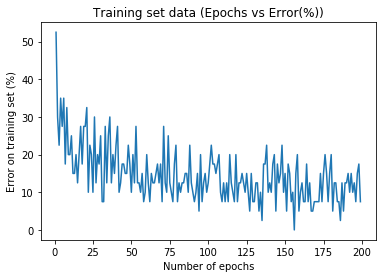

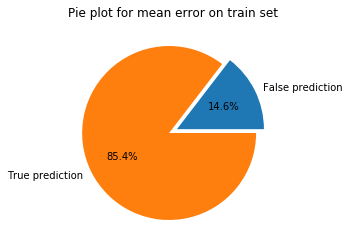

In [114]:
l=list()
for i in error_axis_train:
  l.append(i.cpu().detach().numpy())

mean=np.mean(l)
print("Mean error on train set=",mean,"% \n")
plt.plot(epoch_axis_train,error_axis_train)
plt.title("Training set data (Epochs vs Error(%))")
plt.xlabel("Number of epochs")
plt.ylabel("Error on training set (%)")
plt.show()
explode=(0.05,0.05)

print("\n")
labels=["False prediction","True prediction"]
plt.pie([mean,100-mean],labels=labels,autopct='%1.1f%%',explode=explode)
plt.title("Pie plot for mean error on train set")
plt.show()

# Test set plots

Mean error on test set= 14.820989929599525 % 



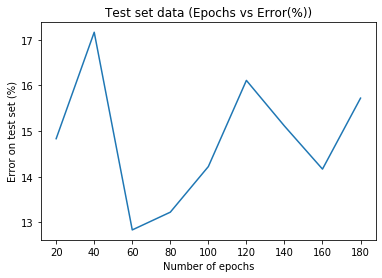

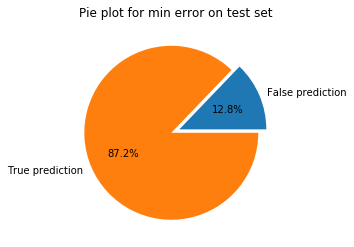

In [115]:
print("Mean error on test set=",np.mean(error_axis_test),"% \n")
plt.plot(epoch_axis_test,error_axis_test)
plt.title("Test set data (Epochs vs Error(%))")
plt.xlabel("Number of epochs")
plt.ylabel("Error on test set (%)")
plt.show()
print("\n")
plt.pie([min(error_axis_test),100-min(error_axis_test)],labels=labels,autopct='%1.1f%%',explode=explode)
plt.title("Pie plot for min error on test set")
plt.show()

## Conclusion

The concatenated architecture performed vastly better than the first the first architecture and slightly better than that of the second architecture with an average mean error of less than 15%

## Inference

Note that though the training time of the Concatenated Architecture is in general much higher compared to the other two, it provided only a slight improvement over the accuracy of the existing architectures. This can also be validated over multiple number of training and test datasets on which these three architectures are being tested upon. 

## Results reproducibility

Note that these architectures have been tested on 6 different training and test datasets out of which the above shown is for the file "trainData__SMOTE_all_10s_f5" which can be found [here](https://github.com/ismail0T/CE7454_project/tree/master/Conv1D).

To reproduce the results concerning to these architectures, run the notebooks (which have these 3 architectures in 3 different notebooks) present in these 6 files which are all found [here](https://github.com/ismail0T/CE7454_project/tree/master/Conv1D):

1. trainData__SMOTE_all_10s_f0
2. trainData__SMOTE_all_10s_f1
3. trainData__SMOTE_all_10s_f2
4. trainData__SMOTE_all_10s_f3
5. trainData__SMOTE_all_10s_f4
6. trainData__SMOTE_all_10s_f5

The link for the above datasets can be found [here](https://drive.google.com/open?id=1I29pxdFzzxvKDmuy4NAKGcCpfepLtIDQ).